Best parameters for k-NN (Phytoplankton): {'n_neighbors': 7, 'weights': 'uniform'}
k-NN Cross-Validation Accuracy Scores (Phytoplankton): [0.88842975 0.91184573 0.91172414 0.91586207 0.90482759]
k-NN Mean Cross-Validation Accuracy (Phytoplankton): 0.9065378550394223
Phytoplankton Classification Report:
              precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00       191
    Level 10       0.68      0.85      0.75        27
     Level 2       0.57      0.50      0.53         8
     Level 3       0.80      0.87      0.84        38
     Level 4       0.99      0.97      0.98       275
     Level 5       0.95      0.98      0.97        57
     Level 6       0.95      0.94      0.95       104
     Level 7       0.74      0.74      0.74        53
     Level 8       0.51      0.41      0.46        51
     Level 9       0.82      0.85      0.84       103

    accuracy                           0.91       907
   macro avg       0.80      0.81      0.80   

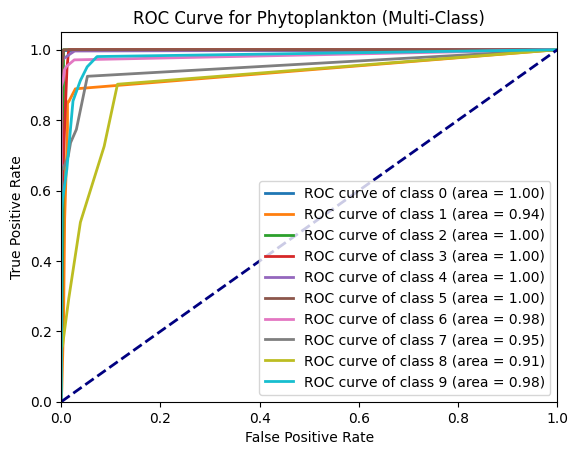

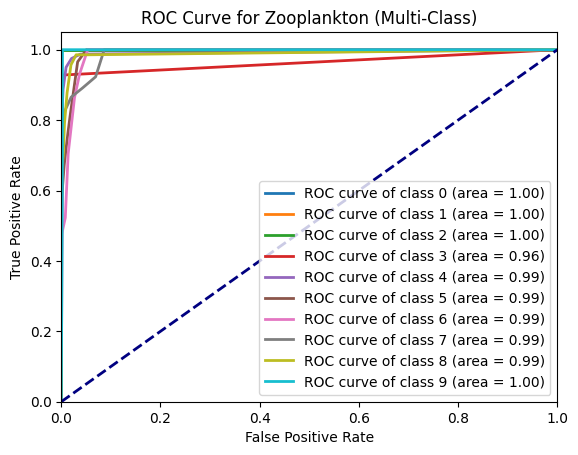

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

# Load the dataset from the CSV file
df = pd.read_csv('6639leveling.csv')

# Features
X = df[['Temp', 'pH', 'TDS', 'Turbidity', 'DO']]

# Labels
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode the labels
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Split the data into training and testing sets
X_train, X_test, y_phyto_train, y_phyto_test, y_zoo_train, y_zoo_test = train_test_split(
    X, y_phyto_encoded, y_zoo_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Hyperparameter tuning for k-NN using GridSearchCV (Phytoplankton)
knn_param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_phyto_train)
best_knn = knn_grid_search.best_estimator_
print(f"Best parameters for k-NN (Phytoplankton): {knn_grid_search.best_params_}")

# Cross-validation for k-NN (Phytoplankton)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_cv_scores = cross_val_score(best_knn, X_train, y_phyto_train, cv=cv, scoring='accuracy')
print("k-NN Cross-Validation Accuracy Scores (Phytoplankton):", knn_cv_scores)
print("k-NN Mean Cross-Validation Accuracy (Phytoplankton):", knn_cv_scores.mean())

# Train the best k-NN model on the entire training data for Phytoplankton
best_knn.fit(X_train, y_phyto_train)

# Predict and evaluate for Phytoplankton
y_phyto_pred = best_knn.predict(X_test)
print("Phytoplankton Classification Report:")
print(classification_report(y_phyto_test, y_phyto_pred, target_names=le_phyto.classes_))
print("Phytoplankton Accuracy:", accuracy_score(y_phyto_test, y_phyto_pred))

# Hyperparameter tuning for k-NN (Zooplankton)
knn_grid_search.fit(X_train, y_zoo_train)
best_knn_zoo = knn_grid_search.best_estimator_
print(f"Best parameters for k-NN (Zooplankton): {knn_grid_search.best_params_}")

# Cross-validation for k-NN (Zooplankton)
knn_cv_scores_zoo = cross_val_score(best_knn_zoo, X_train, y_zoo_train, cv=cv, scoring='accuracy')
print("k-NN Cross-Validation Accuracy Scores (Zooplankton):", knn_cv_scores_zoo)
print("k-NN Mean Cross-Validation Accuracy (Zooplankton):", knn_cv_scores_zoo.mean())

# Train the best k-NN model on the entire training data for Zooplankton
best_knn_zoo.fit(X_train, y_zoo_train)

# Predict and evaluate for Zooplankton
y_zoo_pred = best_knn_zoo.predict(X_test)
print("Zooplankton Classification Report:")
print(classification_report(y_zoo_test, y_zoo_pred, target_names=le_zoo.classes_))
print("Zooplankton Accuracy:", accuracy_score(y_zoo_test, y_zoo_pred))

# Multi-Class ROC Curve for Phytoplankton
y_phyto_prob = best_knn.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le_phyto.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_phyto_test == i, y_phyto_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(le_phyto.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phytoplankton (Multi-Class)')
plt.legend(loc="lower right")
plt.show()

# Multi-Class ROC Curve for Zooplankton
y_zoo_prob = best_knn_zoo.predict_proba(X_test)

fpr_zoo = {}
tpr_zoo = {}
roc_auc_zoo = {}

for i in range(len(le_zoo.classes_)):
    fpr_zoo[i], tpr_zoo[i], _ = roc_curve(y_zoo_test == i, y_zoo_prob[:, i])
    roc_auc_zoo[i] = auc(fpr_zoo[i], tpr_zoo[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(le_zoo.classes_)):
    plt.plot(fpr_zoo[i], tpr_zoo[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc_zoo[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Zooplankton (Multi-Class)')
plt.legend(loc="lower right")
plt.show()
